In [1]:
# Librairies

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

Data Preparation

In [2]:
data_dir = '../input/tiger-hyena-cheetah'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/training")
print(len(classes),'classes :', classes)

Folders : ['training', 'validation']
3 classes : ['Hyena', 'Tiger', 'Cheetah']


In [3]:
dataset = ImageFolder(data_dir + '/training', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 2700


In [4]:
test = ImageFolder(data_dir + '/validation', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 300


In [5]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 400, 400])


Label:  Cheetah (0)


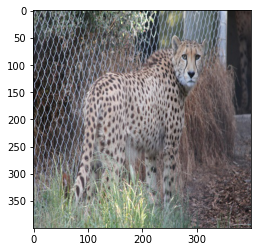

In [6]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

Label:  Tiger (2)


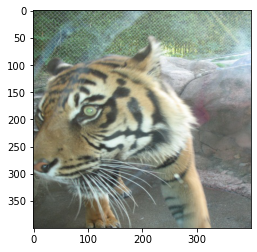

In [8]:
show_example(*dataset[2020])

Label:  Hyena (1)


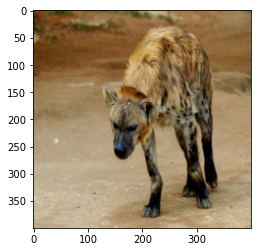

In [21]:
show_example(*dataset[1233])

In [12]:
torch.manual_seed(43)
val_size = 300
train_size = len(dataset) - val_size

In [13]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2400, 300)

In [14]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)


In [9]:
!pip install jovian --upgrade -q

In [10]:
project_name = "Assignment 5 - Course Project"

In [11]:
import jovian
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/shubhankarnandakumar07/Assignment 5 - Course Project


<IPython.core.display.Javascript object>

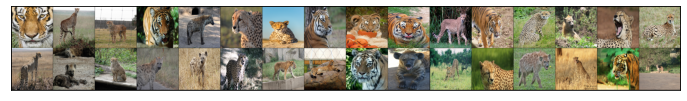

In [15]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
torch.cuda.is_available()

True

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [23]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [24]:
input_size = 3*400*400
output_size = 3

In [25]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.out_layer = nn.Linear(16, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [26]:
model = to_device(Model(input_size, output_size), device)

In [27]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.10118567943573, 'val_acc': 0.3394886553287506}]

In [28]:
history += fit(3, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0926, val_acc: 0.4045
Epoch [1], val_loss: 1.0752, val_acc: 0.4318
Epoch [2], val_loss: 1.0743, val_acc: 0.4273


In [29]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0585, val_acc: 0.4631
Epoch [1], val_loss: 1.0579, val_acc: 0.4401
Epoch [2], val_loss: 1.0580, val_acc: 0.4477
Epoch [3], val_loss: 1.0583, val_acc: 0.4460
Epoch [4], val_loss: 1.0576, val_acc: 0.4460
Epoch [5], val_loss: 1.0568, val_acc: 0.4568
Epoch [6], val_loss: 1.0563, val_acc: 0.4554
Epoch [7], val_loss: 1.0559, val_acc: 0.4568
Epoch [8], val_loss: 1.0564, val_acc: 0.4568
Epoch [9], val_loss: 1.0551, val_acc: 0.4676


In [30]:
history += fit(10, 0.02, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0521, val_acc: 0.4645
Epoch [1], val_loss: 1.0752, val_acc: 0.4472
Epoch [2], val_loss: 1.0402, val_acc: 0.4716
Epoch [3], val_loss: 1.0475, val_acc: 0.4253
Epoch [4], val_loss: 1.1346, val_acc: 0.4034
Epoch [5], val_loss: 1.0219, val_acc: 0.5011
Epoch [6], val_loss: 1.0240, val_acc: 0.4699
Epoch [7], val_loss: 1.0446, val_acc: 0.4608
Epoch [8], val_loss: 1.0889, val_acc: 0.4429
Epoch [9], val_loss: 1.0405, val_acc: 0.4986


Analyze the Model

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

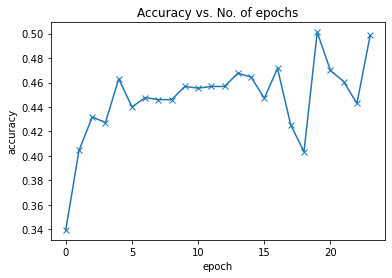

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

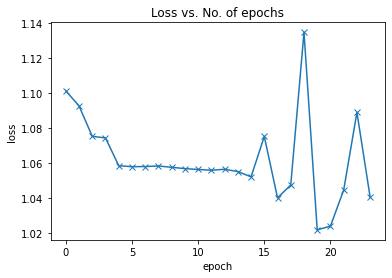

In [34]:
plot_losses(history)

In [35]:
evaluate(model, test_loader)

{'val_loss': 1.0011194944381714, 'val_acc': 0.5099431872367859}

The above model has an accuracy of 50.9%

# **Model 2 : Convolutional Neural Network**

![](http://)We will now try to train the model using CNN Resnet18

In [36]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [37]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.cuda()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [38]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 400, 400])
out.shape: torch.Size([32, 8, 200, 200])


In [39]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [40]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d((3,400,400), 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 3))
        
    def forward(self, xb):
        return self.network(xb)

In [41]:
class CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 3)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [42]:
model = CnnModel2()
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


CnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [43]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 400, 400])
out.shape: torch.Size([32, 3])
out[0]: tensor([0.6471, 0.4138, 0.5985], device='cuda:0', grad_fn=<SelectBackward>)


In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = get_default_device()
device

device(type='cuda')

In [46]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [47]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [48]:
model = to_device(CnnModel2(), device)

In [49]:
evaluate(model, val_loader)

{'val_loss': 1.1238622665405273, 'val_acc': 0.35767045617103577}

In [51]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [52]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6109, val_loss: 0.6020, val_acc: 0.9548
Epoch [1], train_loss: 0.5738, val_loss: 0.5612, val_acc: 1.0000
Epoch [2], train_loss: 0.5747, val_loss: 0.6467, val_acc: 0.9026
Epoch [3], train_loss: 0.5689, val_loss: 0.5696, val_acc: 0.9861
Epoch [4], train_loss: 0.5663, val_loss: 0.6723, val_acc: 0.8787
Epoch [5], train_loss: 0.5667, val_loss: 0.6054, val_acc: 0.9395
Epoch [6], train_loss: 0.5649, val_loss: 0.5735, val_acc: 0.9750
Epoch [7], train_loss: 0.5678, val_loss: 0.6192, val_acc: 0.9210
Epoch [8], train_loss: 0.5639, val_loss: 0.5839, val_acc: 0.9673
Epoch [9], train_loss: 0.5623, val_loss: 0.6597, val_acc: 0.8898


Analyze the Model

In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

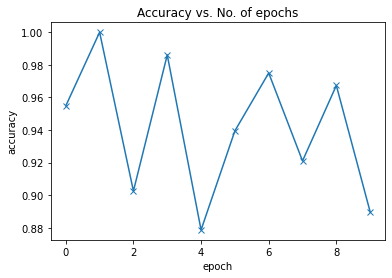

In [54]:
plot_accuracies(history)

In [55]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

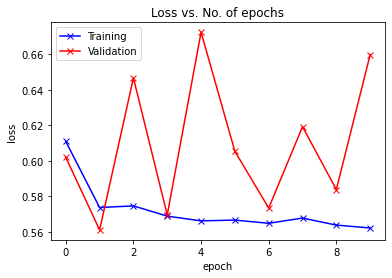

In [56]:
plot_losses(history)

In [57]:
evaluate(model, test_loader)

{'val_loss': 0.6518201231956482, 'val_acc': 0.8957386016845703}

The CNN model has an accuracy of 89.57% as compared to the previous one which had only 50.9%

In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import jovian

<IPython.core.display.Javascript object>

In [3]:
project_name = "Assignment 5 - Course Project"

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/shubhankarnandakumar07/Assignment 5 - Course Project


<IPython.core.display.Javascript object>

In [ ]:
arch = " 4 layers (128,64,32,16)"
lr = [0.001]
epoch = 10

test_acc = 0.8957386016845703
test_loss = 0.6518201231956482

In [ ]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)